In [ ]:
# Connecting notebook with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import sklearn
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

Now, since we have cleaned and merged the data provided through two separate data sources, we can move ahead to understand the data and perform some EDA to gain the insight.

In [ ]:
# importing merged data file of phone reviews and phone metadata
merge_df = pd.read_csv('/content/gdrive/MyDrive/Capstone_Project_Data/merged_data.csv')
merge_df.head()

,Unnamed: 0,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_sentiment,style_type,style_color,brand,title,price,category_cellphone,subcategory_cellphone,description,feature,also_view_brand,rank_cat_type,rank_subcat_type,rank_in_cat,rank_in_sub
0,0,1.0,False,A5JLAU2ARJ0BO,B0000E3GWH,Not available,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,2004-09-21,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.00,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
1,1,4.0,False,A1ACM1CBGORBN1,B0000E3GWH,Not available,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,2004-07-24,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.00,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
2,2,3.0,False,A2V48Q03FZUOSD,B0000E3GWH,Not available,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,2004-07-06,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.00,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
3,3,5.0,True,A1V3TRGWOMA8LC,B0000E3GWH,Not available,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,2004-04-12,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.00,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
4,4,3.0,False,A3NOBH42C7UI5M,B0000E3GWH,Not available,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,2004-02-19,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.00,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100


In [ ]:
# Removing first column and rows with NaN values under reviewText column
merge_df = merge_df.drop("Unnamed: 0", axis=1)
merge_df = merge_df.loc[~pd.isnull(merge_df['reviewText'])]

In [ ]:
sub_cat_list = list(merge_df['rank_subcat_type'].unique())
sub_cat_list

['Carrier Cell Phones',
 'Unlocked Cell Phones',
 'Not available',
 "Carrier Cell Phones'",
 "Unlocked Cell Phones'",
 'Wireless Accessories',
 "Outlet'"]

In [ ]:
merge_df['rank_subcat_type'] = merge_df['rank_subcat_type'].apply(lambda x: "Carrier Cell Phones" if x=="Cell Phones & Accessories > Carrier Cell Phones" else "Wireless Accessories" if x=="Gadgets > Wireless Accessories'" else x)

In [1]:
new_sub_cat_list = []
for i in range(0,len(merge_df.index)):
  string = merge_df['rank_subcat_type'][i]
  find_sub_cat = re.findall(r'\w+',string)
  x = " ".join(find_sub_cat)
  new_sub_cat_list.append(x)
merge_df['rank_subcat_type'] = new_sub_cat_list

NameError: name 'merge_df' is not defined

In [ ]:
merge_df.groupby(['rank_subcat_type'])['brand'].count()

rank_subcat_type
Carrier Cell Phones     11708
Not available            5558
Outlet                   3828
Unlocked Cell Phones    42556
Wireless Accessories      162
Name: brand, dtype: int64

In [ ]:
brands_in_subcat = merge_df.groupby(['rank_subcat_type','brand'])['brand'].count().sort_values(ascending=False)
subcat_brands = pd.DataFrame(brands_in_subcat)
subcat_brands.columns = ['brand_count']
subcat_brands = subcat_brands.reset_index()
subcat_brands

,rank_subcat_type,brand,brand_count
0,Unlocked Cell Phones,Samsung,11003
1,Unlocked Cell Phones,BLU,6896
2,Carrier Cell Phones,Samsung,3474
3,Unlocked Cell Phones,BlackBerry,3452
4,Unlocked Cell Phones,Apple,3241
...,...,...,...
205,Not available,0,5
206,Carrier Cell Phones,Virgin Mobile Slice,5
207,Carrier Cell Phones,Republic Wireless,5
208,Carrier Cell Phones,TracFone,5


In [ ]:
subcat_brands.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/subcat_brands.csv')

In [ ]:
# Creating a function to refine the price column
def price_mapper(string):
  find_price = re.findall(r'\D+', string)
  if len(find_price)>1:
    return 0
  elif len(find_price)==0:
    return 0
  else:
    if len(find_price)==1:
      price = re.findall(r'\d.+', string)
      x = price[0]
      return float(x)

In [ ]:
# Applying price_mapper function to the price column
merge_df['price']=merge_df['price'].apply(price_mapper)

In [ ]:
merge_df.loc[(merge_df['brand']!="Not available") & (merge_df['price']!='Not avialable'), ][['brand','price']]

,brand,price
0,Samsung,0.00
1,Samsung,0.00
2,Samsung,0.00
3,Samsung,0.00
4,Samsung,0.00
...,...,...
63807,Samsung,53.95
63808,Samsung,53.95
63809,Samsung,53.95
63810,Samsung,53.95


In [ ]:
# Creating a new Dataframe to find the top 10 selling brands
brands = merge_df.loc[merge_df['brand']!="Not available"]
brands.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_sentiment,style_type,style_color,brand,title,price,category_cellphone,subcategory_cellphone,description,feature,also_view_brand,rank_cat_type,rank_subcat_type,rank_in_cat,rank_in_sub
0,1.0,False,A5JLAU2ARJ0BO,B0000E3GWH,Not available,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,2004-09-21,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
1,4.0,False,A1ACM1CBGORBN1,B0000E3GWH,Not available,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,2004-07-24,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
2,3.0,False,A2V48Q03FZUOSD,B0000E3GWH,Not available,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,2004-07-06,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
3,5.0,True,A1V3TRGWOMA8LC,B0000E3GWH,Not available,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,2004-04-12,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100
4,3.0,False,A3NOBH42C7UI5M,B0000E3GWH,Not available,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,2004-02-19,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100


In [ ]:
# Creating a dictionary to list the brands names and number of solds by each brand
brand_dict = {}
count = 0
for i in range(0,len(brands.index)):
  if merge_df['brand'][i] not in brand_dict:
    brand_dict[merge_df['brand'][i]] = 1
  else:
    brand_dict[merge_df['brand'][i]] = brand_dict[merge_df['brand'][i]]+1

top_10_brands = sorted(brand_dict, key=brand_dict.get, reverse=True)[0:10]
print(top_10_brands)

['Samsung', 'BLU', 'LG', 'Motorola', 'Nokia', 'Apple', 'BlackBerry', 'HTC', 'Sony', 'Huawei']


In [ ]:
brands = []
brand_prices = []
for i in range(0,len(merge_df.index)):
  if merge_df['brand'][i] in top_10_brands:
    if merge_df['price'][i]> 1: 
      brands.append(merge_df['brand'][i])
      brand_prices.append(merge_df['price'][i])

# Creating a new dataframe to brands and their price range 
prices = pd.DataFrame()
prices['brands'] = brands
prices['brand_prices'] = brand_prices
prices.head()

,brands,brand_prices
0,Motorola,17.99
1,Motorola,17.99
2,Motorola,17.99
3,Motorola,17.99
4,Motorola,17.99


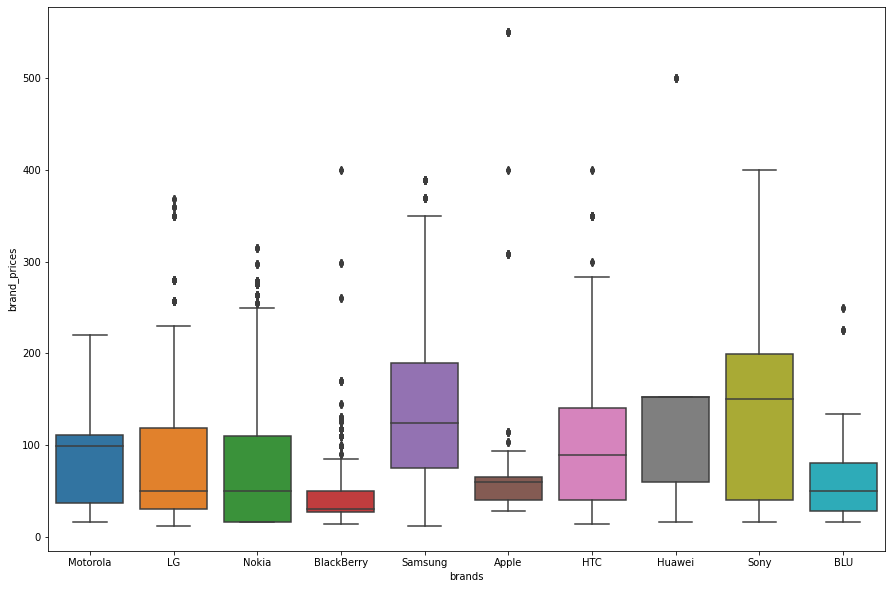

In [ ]:
# plotting the price range of top 10 selling brands
plt.figure(figsize=(15,10))
sns.boxplot(x="brands", y="brand_prices", data=prices)
plt.show()

### Recommendable price range would be below $100

In [ ]:
# creating a csv file for Tableau visualization
prices.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/prices.csv')

In [ ]:
# Finding top 10 selling brands
top_brands_sold = merge_df.loc[merge_df['brand']!="Not available"].groupby('brand')['brand'].count().sort_values(ascending=False)
top_10_brands_sold = pd.DataFrame(top_brands_sold)
top_10_brands_sold.columns = ['brand_sold_count']
top_10_brands_sold = top_10_brands_sold.reset_index()
top_10_brands_sold['Total_Units_Sold_top_10'] = round(100*(top_10_brands_sold['brand_sold_count']/top_10_brands_sold['brand_sold_count'].sum()),0)
top_10_brands_sold = top_10_brands_sold[0:10]

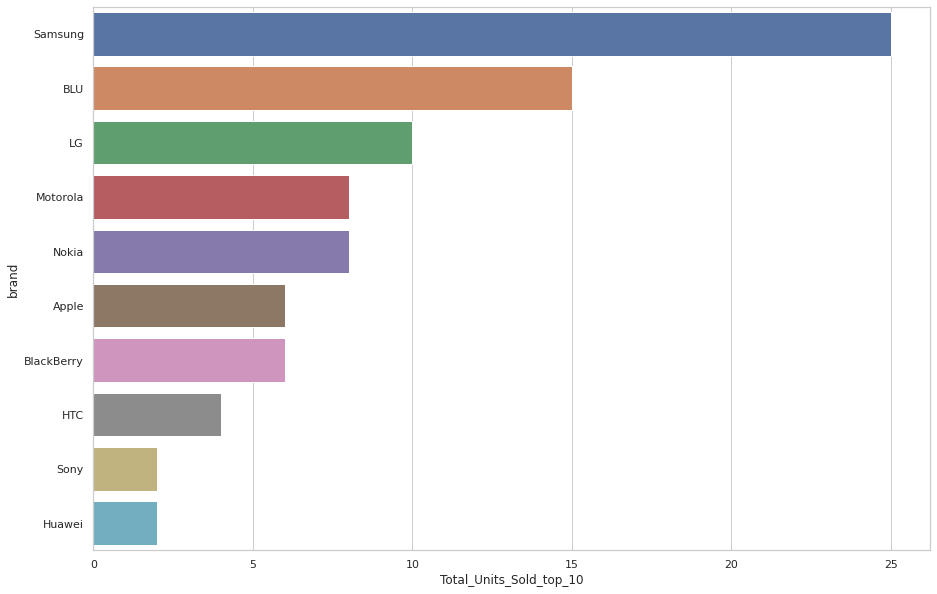

In [ ]:
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.barplot(y="brand", x="Total_Units_Sold_top_10", data=top_10_brands_sold)
plt.show()

### From the above analysis, it is safe to say, that Samsung is the leading the mobile manufacturer in the market.

In [ ]:
pd.DataFrame(merge_df.loc[merge_df['style_color']!="Not available"].groupby('style_color')['style_color'].count().sort_values(ascending=False))

,style_color
style_color,
black,8465
white,6610
gold,1223
blue,941
grey,679
...,...
lavender,1
ocean,1
pebble,1


In [ ]:
merge_df['style_color'] = merge_df['style_color'].apply(lambda x : "gray" if x=="grey" else x)

In [ ]:
# creating a dataframe to capture all the colors and their respective units sold 
top_colors = pd.DataFrame(merge_df.loc[merge_df['style_color']!="Not available"].groupby('style_color')['style_color'].count().sort_values(ascending=False)[0:10])
top_10_colors = pd.DataFrame(top_colors)
top_10_colors.columns = ['style_color_count']
top_10_colors = top_10_colors.reset_index()
top_10_colors.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/top_colors.csv')
top_10_colors


,style_color,style_color_count
0,black,8465
1,white,6610
2,gold,1223
3,gray,1073
4,blue,941
5,silver,565
6,pink,449
7,yellow,296
8,red,259
9,space,218


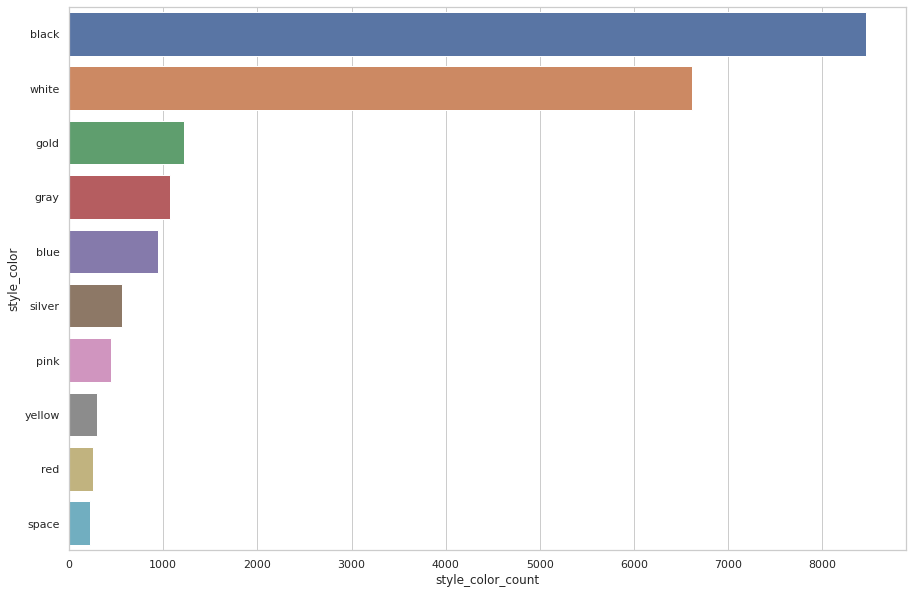

In [ ]:
# plotting the style colors and units sold under each
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.barplot(y="style_color", x="style_color_count", data=top_10_colors)
plt.show()

### Most preferred colors of mobiles are: 1. Black 2. White 3. Gold 4. Gray

In [ ]:
merge_df['review_sentiment_label'] = merge_df['review_sentiment'].map({'POSITIVE':1, 'NEGATIVE':0})

In [ ]:
#Sentiment towards Brands
brand_pos_review = merge_df.loc[merge_df['brand']!="Not available"].groupby('brand')['review_sentiment_label'].sum().sort_values(ascending=False)
brand_pos_reviews = pd.DataFrame(brand_pos_review)
brand_pos_reviews.columns = ['brand_pos_review_count']
brand_pos_reviews = brand_pos_reviews.reset_index()
brand_pos_reviews[0:10]

,brand,brand_pos_review_count
0,Samsung,12107
1,BLU,6724
2,LG,5059
3,Nokia,3904
4,Motorola,3740
5,Apple,2960
6,BlackBerry,2417
7,HTC,1934
8,Sony,1217
9,Huawei,1032


In [ ]:
top_10_brands_sold['brand_pos_review_count'] = brand_pos_reviews['brand_pos_review_count']
top_10_brands_sold['brand_pos_review_count_pct'] = round(100*(top_10_brands_sold['brand_pos_review_count']/top_10_brands_sold['brand_sold_count']),0)
top_10_brands_sold = top_10_brands_sold.sort_values(by='brand_pos_review_count_pct', ascending=False)
# creating a csv file for tableau visualization
top_10_brands_sold.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/top_10_brands.csv')

In [ ]:
top_10_brands_sold

,brand,brand_sold_count,Total_Units_Sold_top_10,brand_pos_review_count,brand_pos_review_count_pct
3,Motorola,4918,8.0,3904,79.0
7,HTC,2453,4.0,1934,79.0
8,Sony,1555,2.0,1217,78.0
4,Nokia,4885,8.0,3740,77.0
2,LG,6652,10.0,5059,76.0
0,Samsung,16191,25.0,12107,75.0
9,Huawei,1399,2.0,1032,74.0
5,Apple,4046,6.0,2960,73.0
1,BLU,9324,15.0,6724,72.0
6,BlackBerry,3655,6.0,2417,66.0


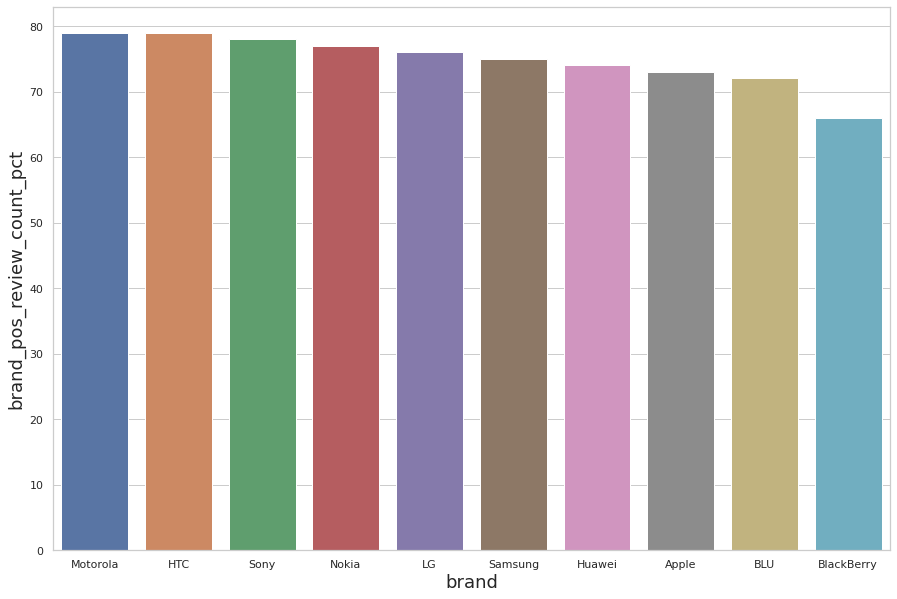

In [ ]:
# plotting the percentage of positive reviews given to top 10 selling mobile phone brands 
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.barplot(x="brand", y="brand_pos_review_count_pct", data=top_10_brands_sold)
plt.xlabel('brand', fontsize=18)
plt.ylabel('brand_pos_review_count_pct', fontsize=18)
plt.show()

### Blackberry has recieved the most negative reviews among the top selling mobile brands.

In [ ]:
# processing data for time-series analysis
from datetime import datetime
first_date = merge_df['unixReviewTime'][0]
first_date_obj = datetime.strptime(first_date, '%Y-%M-%d')
first_date_yr = datetime.strptime(first_date, '%Y-%M-%d').year
first_date_month = datetime.strptime(first_date, '%Y-%M-%d').month
print(first_date_obj)
print(first_date_yr)
print(type(first_date_month))

2004-01-21 00:09:00
2004
<class 'int'>


In [ ]:
# processing data for time series analysis
from datetime import datetime
merge_df['Date_Year'] = merge_df['unixReviewTime'].apply(lambda x: datetime.strptime(x, '%Y-%M-%d').year)
merge_df['Date_Month'] = merge_df['unixReviewTime'].apply(lambda x: datetime.strptime(x, '%Y-%M-%d').month)

In [ ]:
look_up = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
            6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
merge_df['Date_Month'] = merge_df['Date_Month'].apply(lambda x: look_up[x])

In [ ]:
# creating a dataframe for time series analysis of mobile phone market
sales_timeseries = merge_df.loc[merge_df['brand']!="Not available"].groupby(['Date_Year','Date_Month','brand'])['brand'].count()
timeseries = pd.DataFrame(sales_timeseries)
timeseries.columns = ['mobile_sold']
timeseries = timeseries.reset_index()
timeseries.to_csv("/content/gdrive/MyDrive/Capstone_Project_Data/timeseries.csv")
timeseries.head()

,Date_Year,Date_Month,brand,mobile_sold
0,2003,Jan,Samsung,1
1,2004,Jan,Cell Phone,2
2,2004,Jan,Motorola,9
3,2004,Jan,Palm Treo 650,2
4,2004,Jan,Samsung,5


In [ ]:
# creating a dataframe for time series analysis of mobile phone market
sales_reviewtime = merge_df.loc[merge_df['brand']!="Not available"].groupby(['unixReviewTime','brand'])['brand'].count()
reviewtime_sales = pd.DataFrame(sales_reviewtime)
reviewtime_sales.columns = ['mobile_sold']
reviewtime_sales = reviewtime_sales.reset_index()
reviewtime_sales.head()

,unixReviewTime,brand,mobile_sold
0,2003-12-19,Samsung,1
1,2004-01-05,Motorola,1
2,2004-01-22,Motorola,1
3,2004-02-05,Motorola,1
4,2004-02-19,Samsung,1


In [ ]:
# converting dataframe to csv format for visualization in Tableau
reviewtime_sales.to_csv("/content/gdrive/MyDrive/Capstone_Project_Data/reviewtime_sales.csv")

In [ ]:
#filter dataframe with Positive review sentiment
feat_pos = merge_df.loc[merge_df['review_sentiment']=="POSITIVE"]
feat_pos.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_sentiment,style_type,style_color,brand,title,price,category_cellphone,subcategory_cellphone,description,feature,also_view_brand,rank_cat_type,rank_subcat_type,rank_in_cat,rank_in_sub,review_sentiment_label,Date_Year,Date_Month
1,4.0,False,A1ACM1CBGORBN1,B0000E3GWH,Not available,Sherry Berry,I had the Samsung V205 and then I decided to t...,Pretty good phone.. an improvement from my v205,2004-07-24,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,1,2004,Jan
3,5.0,True,A1V3TRGWOMA8LC,B0000E3GWH,Not available,James Beswick,"..and I'm from Europe, where the phones and ne...",The best phone I've ever owned,2004-04-12,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,1,2004,Jan
4,3.0,False,A3NOBH42C7UI5M,B0000E3GWH,Not available,Kepela,This phone is amazingly small and light for a ...,I love the phone but it has some real problems,2004-02-19,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,1,2004,Jan
5,4.0,True,AQZGG5F4JIRXO,B0000E3GWH,Not available,flyingaho,The last year or so we have all seen an explos...,Good phone with some functions missing,2003-12-19,POSITIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,1,2003,Jan
6,5.0,False,A2D95PL909RIO9,B0000SX2U2,Not available,S. M. Kaplan,I received my Treo 600 last Friday from Treoce...,2 thumbs up!!,2003-11-02,POSITIVE,Not available,Not available,Not available,PCS Phone palmOne Treo 600 (Sprint),0.0,Cell Phones & Accessories,Cell Phones,Not available,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,5713484100,880601100,1,2003,Jan


In [ ]:
# Importing negative, positive and stop long words

header_name = ['neg_word']
neg_words = pd.read_csv('/content/gdrive/MyDrive/Capstone_Project_Data/neg_words.txt',header=None, names=header_name)

header_name = ['pos_word']
pos_words = pd.read_csv('/content/gdrive/MyDrive/Capstone_Project_Data/pos_words.txt', header=None,names=header_name)

header_name = ['stop_word_long']
stop_words = pd.read_csv('/content/gdrive/MyDrive/Capstone_Project_Data/stop_words_long.txt', header=None,names=header_name)


In [ ]:
# creating a wholesome list that contains postive, negative and long stopwords
neg = neg_words['neg_word'].to_list()
pos = pos_words['pos_word'].to_list()
stop = stop_words['stop_word_long'].to_list()
import itertools
no_use_words = itertools.chain(neg,pos,stop)
no_use_list = list(no_use_words)
print(len(no_use_list))

7209


In [ ]:
# Importing NLTK package and necessary libraries
from nltk.tokenize import word_tokenize

#tokenizing review text of "POSITIVE" reviews
feat_pos_text = []
for i in range(0,len(feat_pos.index)):
  x = word_tokenize(feat_pos['reviewText'].iloc[i])
  for j in range(0,len(x)):
    feat_pos_text.append(x[j])
print(feat_pos_text[0:10])

['I', 'had', 'the', 'Samsung', 'V205', 'and', 'then', 'I', 'decided', 'to']


In [ ]:
# creating Bag of Words model (BoW) for feature words occured in Positive review text
# Here we will try Lemmatizing techniques to limit the number of repeated and similar words.

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

# Preprocessing Step1: Lower casing the text
feat_pos_text = [word.lower() for word in feat_pos_text]

# Preprocessing Step2: Removing stopwords from text corpus
feat_pos_text = [word for word in feat_pos_text if word not in no_use_list]

# Preprocessing Step4: Applying Lemmatisation on text corpus
all_review_text_lemma = [wordnet_lemmatizer.lemmatize(word) for word in feat_pos_text]

# Joining text
all_review_text_lemma_doc = ",".join(all_review_text_lemma)


In [ ]:
# refining the text obtained after lemmatization using regex
refined_text = []
for i in range(0,len(all_review_text_lemma)):
  string = all_review_text_lemma[i]
  refine = re.findall(r'\w+', string)
  if len(refine)!=0:
    refined_text.append(refine[0])
print(refined_text[0:10])


['samsung', 'v205', 'decided', 'try', 'e715', 'fyi', 'people', 'battery', 'battery', 'completely']


In [ ]:
# Using NLTK FreqDeist to find the frequency of occurance of a word in entire text corpus
word_freq = nltk.FreqDist(refined_text)
sorted(word_freq,key=word_freq.__getitem__, reverse=True)[0:50]

['phone',
 'n',
 's',
 'screen',
 'battery',
 'camera',
 'time',
 'apps',
 'android',
 'price',
 'card',
 'day',
 '2',
 'feature',
 '4',
 '5',
 'm',
 'quality',
 'samsung',
 'device',
 'iphone',
 'life',
 'am',
 'call',
 've',
 'using',
 '3',
 'product',
 'got',
 'update',
 'note',
 'bought',
 'video',
 'look',
 'sim',
 'app',
 'buy',
 'lot',
 'little',
 'galaxy',
 'button',
 '1',
 'picture',
 'feel',
 'lg',
 'data',
 'size',
 'review',
 'month',
 'service']

In [ ]:
# Creating a dataframe that contains all the words after removing negative, positive and stop words from the text corpus od reviews marked as "POSITIVE"
word = list(word_freq.keys())
word_count = list(word_freq.values())
feat_df = pd.DataFrame()
feat_df['words'] = word
feat_df['word_count'] = word_count
feat_df.head()

,words,word_count
0,samsung,7312
1,v205,4
2,decided,1087
3,try,1730
4,e715,5


In [ ]:
# creating a csv file to creat word cloud in Tableau
# feat_df.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/feature_file.csv')

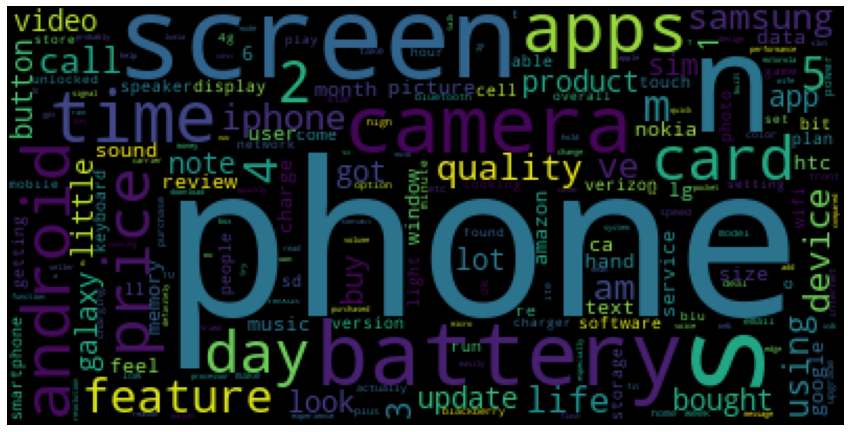

In [ ]:
# visualization of most talked features in Positive reviews given by customers 
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud().generate_from_frequencies(word_freq)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
#filter dataframe with Negative review sentiment
feat_neg = merge_df.loc[merge_df['review_sentiment']=="NEGATIVE"]
feat_neg.head()

,overall,verified,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,review_sentiment,style_type,style_color,brand,title,price,category_cellphone,subcategory_cellphone,description,feature,also_view_brand,rank_cat_type,rank_subcat_type,rank_in_cat,rank_in_sub,review_sentiment_label,Date_Year,Date_Month
0,1.0,False,A5JLAU2ARJ0BO,B0000E3GWH,Not available,Old-and-Wise,This phone is ugly and heavy and has a terribl...,Bad reception,2004-09-21,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,0,2004,Jan
2,3.0,False,A2V48Q03FZUOSD,B0000E3GWH,Not available,Benjamin David,This is the first Samsung phone I have had and...,Not as user friendly as the Motorola V300-,2004-07-06,NEGATIVE,Not available,Not available,Samsung,Samsung SGH E715 - Titanium blue (T-Mobile) Ce...,0.0,Cell Phones & Accessories,Cell Phones,compatible with t mobile cellular service sams...,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,3059436100,880601100,0,2004,Jan
12,3.0,False,A5JLAU2ARJ0BO,B0000SX2U2,Not available,Old-and-Wise,"To be frank, I had high expectations for the T...","Lots of hype, under-delivery",2004-03-13,NEGATIVE,Not available,Not available,Not available,PCS Phone palmOne Treo 600 (Sprint),0.0,Cell Phones & Accessories,Cell Phones,Not available,Not available,Not available,Cell Phones & Accessories,Carrier Cell Phones,5713484100,880601100,0,2004,Jan
22,4.0,False,A1KD8NJPZ01R37,B0000SX3BK,Not available,doppelganger,"In Chicago, the GPS NEVER works (and yes I wen...",Don't do it for the GPS - TeleNav does NOT work,2004-01-05,NEGATIVE,Not available,Not available,Motorola,Motorola i730 Phone (Nextel),0.0,Cell Phones & Accessories,Cell Phones,used good with charger one of the first in a n...,the motorola i730 s advanced features includin...,Not available,Cell Phones & Accessories,Unlocked Cell Phones,1254799100,880601100,0,2004,Jan
23,4.0,False,A3R1KV2ZWGON7J,B0000SX3BK,Not available,Bhodi,This is not a forum for people to express thei...,With all due respect,2010-03-13,NEGATIVE,Not available,Not available,Motorola,Motorola i730 Phone (Nextel),0.0,Cell Phones & Accessories,Cell Phones,used good with charger one of the first in a n...,the motorola i730 s advanced features includin...,Not available,Cell Phones & Accessories,Unlocked Cell Phones,1254799100,880601100,0,2010,Jan


In [ ]:
#tokenizing review text of "NEGATIVE" reviews
feat_neg_text = []
for i in range(0,len(feat_neg.index)):
  x = word_tokenize(feat_neg['reviewText'].iloc[i])
  for j in range(0,len(x)):
    feat_neg_text.append(x[j])
print(feat_neg_text[0:10])

['This', 'phone', 'is', 'ugly', 'and', 'heavy', 'and', 'has', 'a', 'terrible']


In [ ]:
# Here, we will try Lemmatizing techniques to limit the number of repeated and similar words.

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

# Preprocessing Step1: Lower casing the text
feat_neg_text = [word.lower() for word in feat_neg_text]

# Preprocessing Step2: Removing stopwords from text corpus
feat_neg_text = [word for word in feat_neg_text if word not in no_use_list]

# Preprocessing Step4: Applying Lemmatisation on text corpus
all_neg_review_lemma = [wordnet_lemmatizer.lemmatize(word) for word in feat_neg_text]

# Joining text
all_neg_review_lemma_doc = ",".join(all_review_text_lemma)

In [ ]:
# refining the text obtained after lemmatization using regex
refined_neg_text = []
for i in range(0,len(all_neg_review_lemma)):
  string = all_neg_review_lemma[i]
  refine = re.findall(r'\w+', string)
  if len(refine)!=0:
    refined_neg_text.append(refine[0])
print(refined_neg_text[0:10])


['phone', 'heavy', 'user', 'interface', 'techie', 'drop', 'call', 'manhattan', 'moto', 'v600']


In [ ]:
# Using NLTK FreqDeist to find the frequency of occurance of a word in entire text corpus
word_freq_neg = nltk.FreqDist(refined_neg_text)

In [ ]:
# Creating a dataframe that contains all the words after removing negative, positive and stop words from the text corpus of reviews marked as "NEGATIVE"
word = list(word_freq_neg.keys())
word_count = list(word_freq_neg.values())
neg_feat_df = pd.DataFrame()
neg_feat_df['words'] = word
neg_feat_df['word_count'] = word_count
neg_feat_df.head()

,words,word_count
0,phone,16427
1,heavy,113
2,user,370
3,interface,117
4,techie,9


In [ ]:
# creating a csv file to creat word cloud in Tableau
# neg_feat_df.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/neg_feature_file.csv')

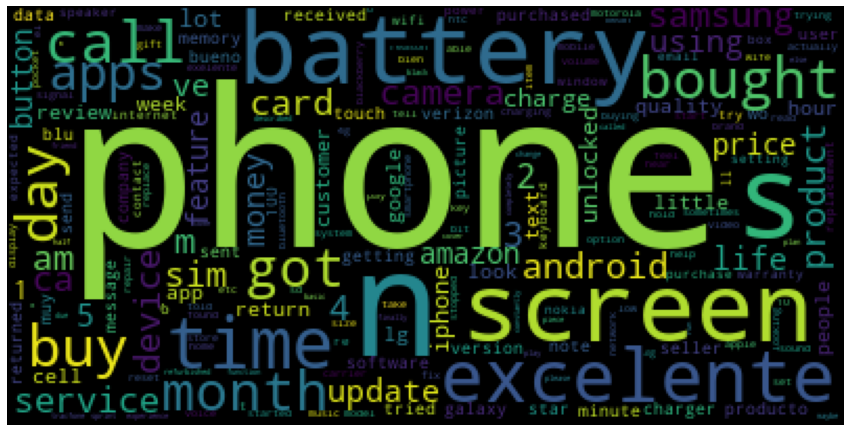

In [ ]:
# visualization of most talked features in Positive reviews given by customers 
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud().generate_from_frequencies(word_freq_neg)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In order to under the brand loyality, we will have to create a measure "Loyality Ratio" which would be the ratio of total number of mobiles sold of a particular brand and the total number of mobiles of the same brand also viewed by the customers while making a purchase.

In [ ]:
# Finding brand loyality
brand_viewed = merge_df.loc[~pd.isnull(merge_df['also_view_brand'])&(merge_df['also_view_brand']!="Not available"), ].also_view_brand
brand_viewed

49       Motorola Motorola Motorola Motorola Motorola M...
50       Motorola Motorola Motorola Motorola Motorola M...
51       Motorola Motorola Motorola Motorola Motorola M...
52       Motorola Motorola Motorola Motorola Motorola M...
53       Motorola Motorola Motorola Motorola Motorola M...
                               ...                        
63749                                           BlackBerry
63750                                           BlackBerry
63751    LG LG LG LG LG LG LG LG LG LG LG LG LG LG LG L...
63752                  Samsung Sony Ericsson Sony Ericsson
63753                  Samsung Sony Ericsson Sony Ericsson
Name: also_view_brand, Length: 13850, dtype: object

In [ ]:
# Tokenizing text under "also_view" column
brand_viewed_token = []
for i in range(0,len(brand_viewed)):
    x = word_tokenize(brand_viewed.iloc[i])
    for j in range(0,len(x)):
      brand_viewed_token.append(x[j])
print(brand_viewed_token[0:10])


['Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola', 'Motorola']


In [ ]:
# Here, we will try Lemmatizing techniques to limit the number of repeated and similar words.

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

# Preprocessing Step1: Lower casing the text
brand_viewed_token = [word.lower() for word in brand_viewed_token]


# Preprocessing Step2: Applying Lemmatisation on text corpus
brand_viewed_token = [wordnet_lemmatizer.lemmatize(word) for word in brand_viewed_token]

In [ ]:
# Using NLTK FreqDeist to find the frequency of occurance of a word in the text corpus of "also_view" column
brand_viewed_count = FreqDist(brand_viewed_token)

In [ ]:
# creating a dataframe to list the brnds and their also_view counts
brand_view = list(brand_viewed_count.keys())
brand_view_count = list(brand_viewed_count.values())
loyality = pd.DataFrame()
loyality['brand'] = brand_view
loyality['brand_view_count'] = brand_view_count
loyality.head()

,brand,brand_view_count
0,motorola,30785
1,nokia,27838
2,lg,86048
3,sony,11157
4,ericsson,1177


In [ ]:
# creating a dataframe to list the brands with their data available of "also_view"
brands_purchased = merge_df.loc[~pd.isnull(merge_df['also_view_brand'])&(merge_df['also_view_brand']!="Not available"), ].groupby('brand')['brand'].count().sort_values(ascending=False)
purchased_brands = pd.DataFrame(brands_purchased)
purchased_brands.columns = ['brands_purchased_count']
purchased_brands = purchased_brands.reset_index()
purchased_brands['brand'] = [brand.lower() for brand in purchased_brands['brand']]
purchased_brands[0:10]

,brand,brands_purchased_count
0,samsung,4101
1,lg,1704
2,motorola,1599
3,blackberry,1531
4,nokia,1383
5,apple,1244
6,htc,870
7,lgic,262
8,sony,196
9,pantech,182


In [ ]:
# merging data of brands sold with brands viewed
loyality = loyality.merge(purchased_brands, how='left', on='brand')
loyality[0:10]

,brand,brand_view_count,brands_purchased_count
0,motorola,30785,1599.0
1,nokia,27838,1383.0
2,lg,86048,1704.0
3,sony,11157,196.0
4,ericsson,1177,NaN
5,kyocera,24985,43.0
6,blackberry,46151,1531.0
7,sanyo,1631,35.0
8,firefly,11,11.0
9,boost,531,NaN


In [ ]:
# sorting the dataframe on brands purchase count and checking their loyality ratio 
loyality = loyality.fillna(0)
loyality = loyality.sort_values(by='brands_purchased_count', ascending=False)
loyality['loyality_ratio'] = round(loyality['brands_purchased_count']/loyality['brand_view_count'],3)
loyality = loyality[0:7]
loyality

,brand,brand_view_count,brands_purchased_count,loyality_ratio
11,samsung,125340,4101.0,0.033
2,lg,86048,1704.0,0.020
0,motorola,30785,1599.0,0.052
6,blackberry,46151,1531.0,0.033
1,nokia,27838,1383.0,0.050
19,apple,16187,1244.0,0.077
13,htc,30969,870.0,0.028


In [ ]:
# # creating a csv file to creat visualizaiton in Tableau
loyality.to_csv('/content/gdrive/MyDrive/Capstone_Project_Data/loyality.csv')

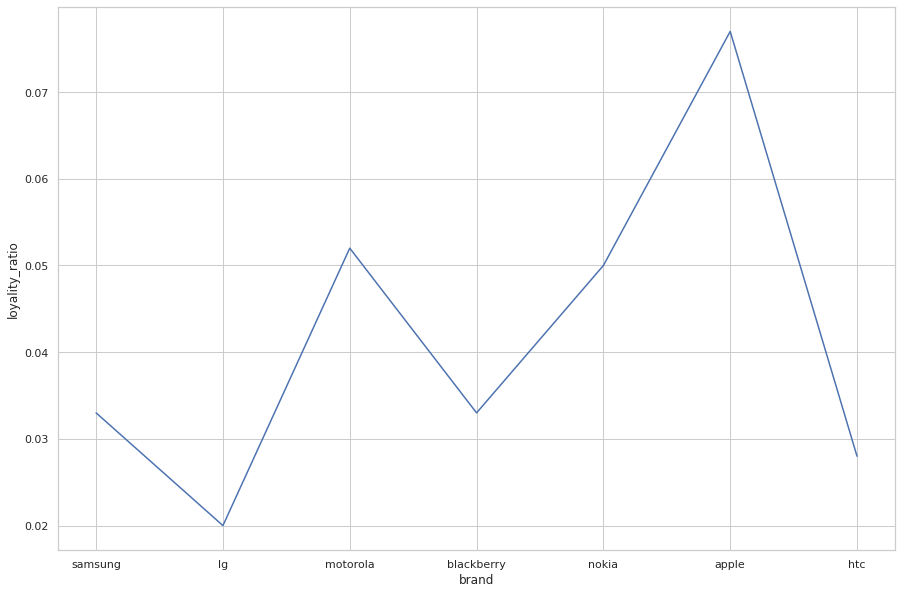

In [ ]:
# plotting loyality ratio of top brands
plt.figure(figsize=(15,10))
sns.set_theme(style="whitegrid")
sns.lineplot(data=loyality[0:7], x="brand", y="loyality_ratio")
plt.show()

Apple has the highest loyality ratio among other brands